<img src="https://assets.ensam.eu/logo/fr/logo-trans-322x84.png" style="width:256px" >

In [1]:
# --> Standard Python packages.
import numpy as np
import matplotlib.pyplot as plt

# --> LTI system related utilities.
from scipy.signal import lti, dlti, dlsim

# **Kalman Filtering**

Let us consider a discrete-time linear time invariant dynamical system

$$
\begin{aligned}
    \mathbf{x}_{t+1} & = \mathbf{Ax}_t + \mathbf{w}_t \\
    \mathbf{y}_t     & = \mathbf{Cx}_t + \mathbf{v}_t,
\end{aligned}
$$

where $\mathbf{x} \in \mathbb{R}^n$ is the state vector of the system and $\mathbf{y} \in \mathbb{R}^q$ the measurements taken.
The matrix $\mathbf{A} \in \mathbb{R}^{n \times n}$ describes the natural dynamics of the system.
We will assume throughout this notebook that $\mathbf{A}$ has all of its eigenvalues inside the unit circle such that the system is stable.
The matrix $\mathbf{C} \in \mathbb{R}^{q \times n}$ is the measurement operator.
It describes the type of sensors used in the experiment.
We also assume that the dynamics are influenced by Gaussian random fluctuations $\mathbf{w}_t \sim \mathcal{N}(\mathbf{0}, \mathbf{W})$ with $\mathbf{W} \in \mathbb{R}^{n \times n}$ the symmetric positive definite covariance matrix of this process noise.
Likewise, we suppose that our measurements are contaminated with some Gaussian random noise $\mathbf{v}_t \sim \mathcal{N}(\mathbf{0}, \mathbf{V})$ with $\mathbf{V} \in \mathbb{R}^{q \times q}$ the symmetric positive definite covariance matrix of this sensor noise.
We also assume that both of these noise are $\delta$-correlated in time and independent, i.e.

$$
\begin{aligned}
    \mathbb{E} \left[ \mathbf{w}_t \mathbf{w}_s^* \right] & = \mathbf{0} \quad \text{for } t \neq s \\
    \mathbb{E} \left[ \mathbf{v}_t \mathbf{v}_s^* \right] & = \mathbf{0} \quad \text{for } t \neq s \\
    \mathbb{E} \left[ \mathbf{v}_t \mathbf{w}_s^* \right] & = \mathbf{0} \quad \text{for all } t \text{ and } s.
\end{aligned}
$$

Our last assumption finally is that the initial condition $\mathbf{x}_0$ is drawn from a multivariate distribution with mean $\bar{\mathbf{x}}_0$ and covariance $\boldsymbol{\Sigma}_0$, i.e.

$$
\mathbf{x}_0 \sim \mathcal{N}(\bar{\mathbf{x}}_0, \boldsymbol{\Sigma}_0).
$$

Our objective in this notebook will be to design an *estimator* which, given knowledge of $\mathbf{A}$, $\mathbf{B}$, $\mathbf{C}$, $\mathbf{W}$, $\mathbf{V}$, $\bar{\mathbf{x}}_0$, $\boldsymbol{\Sigma}_0$ and noise-contaminated measurements $\left\{ \mathbf{y}_t \right\}_{t=0, T}$ returns the most likely state sequence $\left\{ \hat{\mathbf{x}}_t \right\}_{t=0, T}$.
The system will consider is the pendulum on a cart, also known as **cartpole**.
It is a classic problem in control theory.
A depiction of this sytem is shown below

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/00/Cart-pendulum.svg/300px-Cart-pendulum.svg.png" style="margin:auto"/>

</br>

Note that while this schematic represents the inverted pendulum, we will actually consider the case where the pendulum is in the downward direction.
The cells below define the corresponding discrete LTI stochastic system.

In [2]:
# --> State-space model.
def state_space_model(params, dt=0.01):
    """
    This function sets up the state-space model for CartPole.

    INPUT
    -----

    params :    python list
                Physical parameters of the system. 

    dt     :    float
                Sampling period for the discretization of the dynamics.

    RETURN
    ------

    dynsys :    scipy.signal.dlti
                State-space model encapsulated in the scipy-specific object.
    """

    # --> Unpack parameters.
    m, M, L, g, δ = params

    # --> Dynamics matrix.
    A = np.array([
        [0.0, 1.0, 0.0, 0.0],                # Equation for the velocity dx/dt = ẋ
        [0.0, -δ/M, -m*g/M, 0.0],            # Equation for the cart's acceleration.
        [0.0, 0.0, 0.0, 1.0],                # Equation for the pendulum angular velocity dθ/dt = θ̇
        [0.0, δ/(M*L), (m+M)*g/(M*L), 0.0]   # Equation for the pendulum angular acceleration.
    ])

    # --> Input-to-state matrix.
    B = np.array([
        [0.0],
        [1.0/M],
        [0.0],
        [-1.0/(M*L)]
    ])

    # --> Measurement operator.
    C = np.array([[1.0, 0.0, 0.0, 0.0]])#, 
                  # [0.0, 0.0, 0.0, 1.0]])

    # --> Feedthrough matrix.
    D = np.zeros((len(C), len(B.T)))

    # --> Continuous-time state space model.
    ssm = lti(A, B, C, D)

    return ssm

In [3]:
# --> Parameters of the system.
params = m, M, L, g, δ = 1, 5, 2, -10, 1

# --> Create the discrete-time state-space model.
ssm = state_space_model(params)

# --> Get the continuous-time matrices.
A, B, C, D = ssm.A, ssm.B, ssm.C, ssm.D

# --> Dimensions of the system.
m, n = C.shape ; p = B.shape[1]

#####################################
#####     INITIAL CONDITION     #####
#####################################

# --> Parameters of the initial condition distribution.
x̄0 = np.zeros(n)
Σ0 = np.eye(n)

#################################
#####     PROCESS NOISE     #####
#################################

# --> Parameters of the continuous time process noise.
w0 = np.zeros(n)
W = 0.01*B @ np.eye(p) @ B.T

################################
#####     SENSOR NOISE     #####
################################

# --> Parameters of the sensor noise distribution.
v0 = np.zeros(len(ssm.C))

V = 0.1*np.eye(m)

##################################
#####     DISCRETIZATION     #####
##################################

from scipy.linalg import expm

# --> Sampling period.
dt = 0.01

# --> Discretization step.
F = np.block([[-A, W], [np.zeros_like(A), A.T]]) ; G = expm(dt*F)

# --> Dynamics matrix.
A = G[n:, n:].T #expm(dt*A)

# --> Process noise covariance matrix.
W = A @ G[:n, n:]

# --> Resulting discrete-time LTI stochastic system.
ssm = dlti(A, np.eye(n), C, np.zeros((m, n)), dt=dt)

Let us simulate this sytem.

In [4]:
#######################################
#####     SIMULATE THE SYSTEM     #####
#######################################

from scipy.stats import multivariate_normal as mvn

# --> Time-horizon.
Th = 25.0

# --> Number of time-steps.
nt = int(Th / ssm.dt) + 1

# --> Sample the initial condition.
x0 = mvn(x̄0, Σ0).rvs()

# --> Sample the sensor noise.
v = mvn(v0, V).rvs(nt)

# --> Sample process noise.
w = mvn(w0, W, allow_singular=True).rvs(nt)

# --> Simulate the system.
t, y_true, x_true = dlsim(ssm, w, x0=x0)

# --> Noise corrupted measurements.
y = y_true + v.reshape(-1, m)

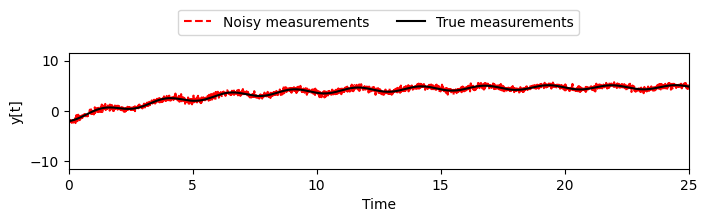

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(8, 1.5))

ax.plot(t, y[:, 0], color="red", ls="--", label="Noisy measurements")
ax.plot(t, y_true[:, 0], color="black", label="True measurements")

ax.set(xlim=(0, Th), ylim=(-2*abs(y).max(), 2*abs(y).max()))
ax.set(xlabel="Time", ylabel="y[t]")
ax.legend(loc="lower center", bbox_to_anchor=(0.5, 1.1), ncol=2)

plt.savefig("../slides/imgs/kalman_measurements.png", bbox_inches="tight", dpi=1200, transparent=True)

The figure above shows the true measurements and their noisy version obtained from this simulation.
Our goal will be to estimate all the other state variables using solely these measurements and prior knowledge of the system matrices $\mathbf{A}$ and $\mathbf{C}$.

---

## **Kalman-Bucy smoother**

For the sake of simplicity, let us begin by considering an ordinary least-squares estimator.
The corresponding likelihood function is defined as

$$
\begin{aligned}
\mathcal{L}(\hat{\mathbf{x}} \vert \cdots) = & \prod_{t=0}^{T} \exp \left( -\dfrac12 \left( \mathbf{y}_t - \mathbf{C} \hat{\mathbf{x}}_t \right)^* \left( \mathbf{y}_t - \mathbf{C} \hat{\mathbf{x}}_t \right) \right) & \text{(Likelihood associated to the measurements)} \\
& \times \prod_{t=0}^{T-1} \exp \left( -\dfrac12 \left( \hat{\mathbf{x}}_{t+1} - \mathbf{A} \hat{\mathbf{x}}_t \right)^* \left( \hat{\mathbf{x}}_{t+1} - \mathbf{A} \hat{\mathbf{x}}_t \right) \right) & \text{(Prior on the dynamics of $\hat{\mathbf{x}}_t$)}
\end{aligned}
$$

Our objective is to find the state sequence $\left\{ \hat{\mathbf{x}}_t \right\}_{t=0, T}$ maximizing this likelihood function.
Directly optimizing the likelihood function often is numerically intractable because of floating point errors.
An equivalent problem is to minimize the negative logarithm of this likelihood.
Doing so, all the products are transformed into sums and we get rid of the exponentials.
This bring us to the following quadratic program

$$
\begin{aligned}
\mathrm{minimize} \quad & \dfrac12 \sum_{t=0}^{T} \left( \mathbf{y}_t - \mathbf{C} \hat{\mathbf{x}}_t \right)^* \left( \mathbf{y}_t - \mathbf{C} \hat{\mathbf{x}}_t \right) \\
                        & + \dfrac12 \sum_{t=0}^{T-1} \left( \hat{\mathbf{x}}_{t+1} - \mathbf{A} \hat{\mathbf{x}}_t \right)^* \left( \hat{\mathbf{x}}_{t+1} - \mathbf{A} \hat{\mathbf{x}}_t \right)
\end{aligned}
$$

For the sake of notational simplicity, let us denote by $\mathcal{J}_t(\hat{\mathbf{x}}_t)$ the following component of our objective function

$$
\begin{aligned}
\mathcal{J}_t(\hat{\mathbf{x}}_t) = & \dfrac12 \left( \mathbf{y}_t - \mathbf{C} \hat{\mathbf{x}}_t \right)^* \left( \mathbf{y}_t - \mathbf{C} \hat{\mathbf{x}}_t \right) \quad & \text{(Measurement error)} \\
                                    & + \dfrac12 \left( \left( \hat{\mathbf{x}}_t - \mathbf{A} \hat{\mathbf{x}}_{t-1} \right)^* \left( \hat{\mathbf{x}}_t - \mathbf{A} \hat{\mathbf{x}}_{t-1} \right) + \left( \hat{\mathbf{x}}_{t+1} - \mathbf{A} \hat{\mathbf{x}}_{t} \right)^* \left( \hat{\mathbf{x}}_{t+1} - \mathbf{A} \hat{\mathbf{x}}_{t} \right) \right) \quad & \text{(Evolution equation)}
\end{aligned}
$$

The first order optimality conditions with respect to $\hat{\mathbf{x}}_{t}$ read

$$
-\mathbf{A} \hat{\mathbf{x}}_{t-1} + \left( \mathbf{C}^* \mathbf{C} + \mathbf{I} + \mathbf{A}^* \mathbf{A} \right) \hat{\mathbf{x}}_t - \mathbf{A}^* \hat{\mathbf{x}}_{t+1} = \mathbf{C}^* \mathbf{y}_t.
$$

For $t = 0$ and $t = T$, the corresponding optimal conditions imply

$$
\left( \mathbf{C}^* \mathbf{C} + \mathbf{A}^* \mathbf{A} \right) \hat{\mathbf{x}}_0 - \mathbf{A}^* \hat{\mathbf{x}}_{1} = \mathbf{C}^* \mathbf{y}_0
$$

and

$$
-\mathbf{A} \hat{\mathbf{x}}_{T-1} + \left( \mathbf{C}^* \mathbf{C} + \mathbf{I} \right) \hat{\mathbf{x}}_T = \mathbf{0}.
$$

Combining all of these equations leads to the following linear system

$$
\begin{bmatrix}
\left( \mathbf{C}^* \mathbf{C} + \mathbf{A}^* \mathbf{A} \right) & - \mathbf{A}^* & \mathbf{0} & \cdots \\
-\mathbf{A} & \left( \mathbf{C}^* \mathbf{C} + \mathbf{I} + \mathbf{A}^* \mathbf{A} \right) & -\mathbf{A}^* & \mathbf{0} \\
\mathbf{0} & -\mathbf{A} & \left( \mathbf{C}^* \mathbf{C} + \mathbf{I} + \mathbf{A}^* \mathbf{A} \right) & -\mathbf{A}^* &  \\
\vdots & \ddots & \ddots & \ddots & \\
& \mathbf{0} & -\mathbf{A} & \left( \mathbf{C}^* \mathbf{C} + \mathbf{I} + \mathbf{A}^* \mathbf{A} \right) & -\mathbf{A}^* \\
& & \mathbf{0} & -\mathbf{A} & \mathbf{C}^* \mathbf{C} + \mathbf{I} 
\end{bmatrix}
\begin{bmatrix}
\hat{\mathbf{x}}_0 \\ \hat{\mathbf{x}}_1 \\ \vdots \\ \vdots \\ \hat{\mathbf{x}}_{T-1} \\ \hat{\mathbf{x}}_T
\end{bmatrix}
=
\begin{bmatrix}
\mathbf{C}^* \mathbf{y}_0 \\ 
\mathbf{C}^* \mathbf{y}_1 \\
\vdots \\
\vdots \\
\mathbf{C}^* \mathbf{y}_{T-1} \\
\mathbf{C}^* \mathbf{y}_{T}
\end{bmatrix}.
$$

Note that, from a theoretical point of view, we assume $\mathbf{V} \propto \mathbf{I}$ and $\mathbf{W} \propto \mathbf{I}$.
Although this is slightly inconsistent with our system, it is not a big issue as the least-square estimator is quite robust to model mispecification.
We will see later how to incorporate prior knowledge of these covariance matrices in the estimation problem.
Let us now nonetheless construct this system and solve it using `numpy`/`scipy`.
Since this procedure estimates the whole state sequence simultaneously, we will denote it as a *batch estimator*.

In [6]:
def batch_estimator(y, ssm):
    """
    Construction of the batch least-squares estimator to obtain the most likely state
    sequence { x̂[t] } from the sequence of measurements { y[t] } and knowledge of
    various properties of the system.

    INPUT
    -----

    y : numpy array, shape (nt, m)
        Sequence of noisy measurements.

    ssm : dlti object
          State-space model of the system.

    RETURN
    ------

    x : numpy array, shape (nt, n)
        Batch estimate of the most likelihood state sequence.


    NOTE: The block tridiagonal system is solved with a specialized version of
          the Thomas algorithm. This python implementation is not however
          optimized and should not be used in production.
    """

    # --> System matrices.
    A, C = ssm.A, ssm.C
    
    # --> Dimensions of the problem.
    m, n = C.shape # Number of sensors/states.
    nt   = len(y)  # Length of the estimation window.

    ################################################################
    #####     BUILDS THE BLOCKS OF THE TRI-DIAGONAL MATRIX     #####
    ################################################################

    # --> Lower diagonal blocks.
    L = (nt-1) * [ -A ]

    # --> Diagonal blocks.
    D = [ C.T @ C + A.T @ A ]                       # D[0, 0] block.
    D += (nt-2) * [ C.T @ C + np.eye(n) + A.T @ A ] # D[i, i] blocks
    D += [ C.T @ C + np.eye(n) ]                              # D[T, T] block.

    # --> Right-hand side vector.
    b = [C.T @ y[i] for i in range(nt)]
    

    #################################################
    #####     BLOCK TRI-DIAG. THOMAS SOLVER     #####
    #################################################

    # --> Initialize factorization.
    Q, U, w = [], [], []
    Q.append( D[0] ) ; w.append( np.linalg.solve(Q[0], b[0]) )

    # --> Forward substitution.
    for i in range(1, nt):
        # --> Update off-diagonal block.
        U.append( np.linalg.inv(Q[i-1]) @ L[i-1].T )

        # --> Update diagonal block.
        Q.append( D[i] - L[i-1] @ U[i-1] )

        # --> Update forward solution.
        w.append( np.linalg.solve(Q[i], b[i] - L[i-1] @ w[i-1]) )

    # --> Backward substitution.
    x = w.copy()
    for i in range(len(U)-1, -1, -1):
        x[i] = w[i] - U[i] @ x[i+1]
        
    return np.asarray(x)

Given our sequence of measurements $\left\{ \mathbf{y}_t \right\}_{t=0, T-1}$ we can now use `batch_estimator` to obtain the estimate of the state sequence.

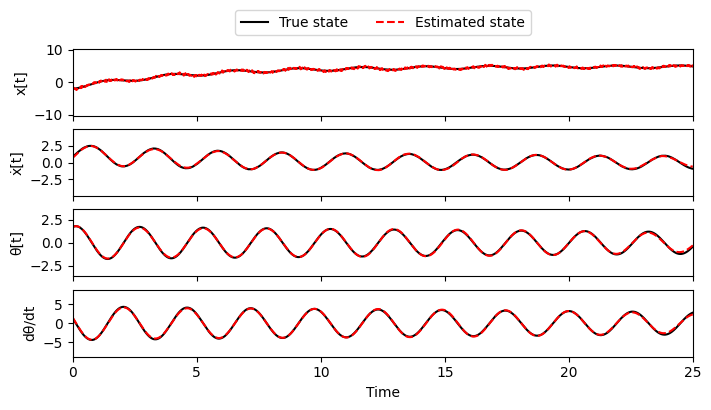

In [8]:
# --> Run the batch estimation.
x̂ = batch_estimator(y, ssm)

# --> Plot the figure.
fig, axes = plt.subplots(n, 1, figsize=(8, 4), sharex=True)

for i, ax in enumerate(axes):
    ax.plot(t, x_true[:, i], color="black", label="True state")
    ax.plot(t, x̂[:, i], color="red", ls="--", label="Estimated state")
    ax.set(xlim=(0, Th))
    ax.set(ylim=(-2*abs(x_true[:, i]).max(), 2*abs(x_true[:, i]).max()))

axes[0].legend(loc="lower center", bbox_to_anchor=(0.5, 1.1), ncol=2)

ylabels = ["x[t]", "ẋ[t]", "θ[t]", "dθ/dt"]
for i, ylabel in enumerate(ylabels):
    axes[i].set(ylabel=ylabel)
    
axes[-1].set(xlabel="Time")


plt.savefig("../slides/imgs/kalman_smoother.png", bbox_inches="tight", dpi=1200, transparent=True)

The figure above depicts the estimates of the state variables obtained from the batch estimator.
Pause and ponder for a second and think about how impressive these results are.
Even though we only have noisy measurements of the cart's position, the batch estimation procedure is able to infer the time evolution of the other state variables we did not actually measure.
This is quite incredible when you think about it.

It does have a problem though.
What if we have a new measurement $\mathbf{y}_{T+1}$ and want to estimate the corresponding state $\mathbf{x}_{T+1}$?
A naïve approach would be to construct the corresponding problem

$$
\begin{bmatrix}
\left( \mathbf{C}^* \mathbf{C} + \mathbf{A}^* \mathbf{A} \right) & - \mathbf{A}^* & \mathbf{0} & \cdots \\
-\mathbf{A} & \left( \mathbf{C}^* \mathbf{C} + \mathbf{I} + \mathbf{A}^* \mathbf{A} \right) & -\mathbf{A}^* & \mathbf{0} \\
\mathbf{0} & -\mathbf{A} & \left( \mathbf{C}^* \mathbf{C} + \mathbf{I} + \mathbf{A}^* \mathbf{A} \right) & -\mathbf{A}^* &  \\
\vdots & \ddots & \ddots & \ddots & \\
& \mathbf{0} & -\mathbf{A} & \left( \mathbf{C}^* \mathbf{C} + \mathbf{I} + \mathbf{A}^* \mathbf{A} \right) & -\mathbf{A}^* \\
& & \mathbf{0} & -\mathbf{A} & \mathbf{C}^* \mathbf{C} + \mathbf{I} + {\color{red} \mathbf{A}^*\mathbf{A}} & {\color{red} -\mathbf{A}^*} \\
& & & \mathbf{0} & {\color{red} -\mathbf{A}} &  {\color{red} \mathbf{C}^* \mathbf{C} + \mathbf{I}}
\end{bmatrix}
\begin{bmatrix}
\hat{\mathbf{x}}_0 \\ \hat{\mathbf{x}}_1 \\ \vdots \\ \vdots \\ \hat{\mathbf{x}}_{T-1} \\ \hat{\mathbf{x}}_T \\ {\color{red} \hat{\mathbf{x}}_{T+1}}
\end{bmatrix}
=
\begin{bmatrix}
\mathbf{C}^* \mathbf{y}_0 \\ 
\mathbf{C}^* \mathbf{y}_1 \\
\vdots \\
\vdots \\
\mathbf{C}^* \mathbf{y}_{T-1} \\
\mathbf{C}^* \mathbf{y}_{T} \\
{\color{red} \mathbf{C}^* \mathbf{y}_{T+1}}
\end{bmatrix}.
$$

This problem is almost the same as before except for the addition of the terms in red, i.e. one new block-row and one block-column.
Solving it from scratch thus seems like a waste of computational resources: except for $\hat{\mathbf{x}}_{T+1}$, we can expect all the other components of the solution to be almost identical as the ones previously computed.
Moreover, as $T \to \infty$, the problem becomes intractable from a computational point of view.
Luckily, we can still to devise an efficient and recursive procedure to solve this problem.

### **Forward-Backward recursions**

Before looking at how to extend the estimation problem from time $t=T$ to $t=T+1$, let us look once more at our original problem, i.e. estimating the most likely state sequence from $t=0$ to $t=T$ given measurements $\left\{ \mathbf{y}_t \right\}_{t=0, T}$.
The problem we have to solve is

$$
\begin{bmatrix}
\left( \mathbf{C}^* \mathbf{C} + \mathbf{A}^* \mathbf{A} \right) & - \mathbf{A}^* & \mathbf{0} & \cdots \\
-\mathbf{A} & \left( \mathbf{C}^* \mathbf{C} + \mathbf{I} + \mathbf{A}^* \mathbf{A} \right) & -\mathbf{A}^* & \mathbf{0} \\
\mathbf{0} & -\mathbf{A} & \left( \mathbf{C}^* \mathbf{C} + \mathbf{I} + \mathbf{A}^* \mathbf{A} \right) & -\mathbf{A}^* &  \\
\vdots & \ddots & \ddots & \ddots & \\
& \mathbf{0} & -\mathbf{A} & \left( \mathbf{C}^* \mathbf{C} + \mathbf{I} + \mathbf{A}^* \mathbf{A} \right) & -\mathbf{A}^* \\
& & \mathbf{0} & -\mathbf{A} & \mathbf{C}^* \mathbf{C} + \mathbf{I} 
\end{bmatrix}
\begin{bmatrix}
\hat{\mathbf{x}}_0 \\ \hat{\mathbf{x}}_1 \\ \vdots \\ \vdots \\ \hat{\mathbf{x}}_{T-1} \\ \hat{\mathbf{x}}_T
\end{bmatrix} =
\begin{bmatrix}
\mathbf{C}^* \mathbf{y}_0 \\ 
\mathbf{C}^* \mathbf{y}_1 \\
\vdots \\
\vdots \\
\mathbf{C}^* \mathbf{y}_{T-1} \\
\mathbf{C}^* \mathbf{y}_{T}
\end{bmatrix}.
$$

This matrix has a particular structure: it is a **symmetric positive-definite block tridiagonal** matrix with $T+1$ blocks of size $n \times n$.
While solving this problem with a general-purpose linear solver would incur a computational cost scaling as $\mathcal{O}( (T+1)^3 n^3)$, we can actually leverage this particular structure to solve it far more efficiently.
In the process, we'll also obtain a recursive filter we can use for real-time forecasting.

**A small detour through numerical linear algebra -** Consider a simplified version of the problem above with only 3 blocks.
The problem we wish to solve thus reads

$$
\begin{bmatrix}
\mathbf{D}_0 & \mathbf{L}_0^* &               \\
\mathbf{L}_0 & \mathbf{D}_1   & \mathbf{L}_1^* \\
            & \mathbf{L}_1   & \mathbf{D}_2
\end{bmatrix}
\begin{bmatrix}
\mathbf{z}_0 \\ \mathbf{z}_1 \\ \mathbf{z}_2
\end{bmatrix} =
\begin{bmatrix}
\mathbf{b}_0 \\ \mathbf{b}_1 \\ \mathbf{b}_2
\end{bmatrix}.
$$

This linear system can be solved efficiently using a block version of the [Thomas algorithm](https://en.wikipedia.org/wiki/Tridiagonal_matrix_algorithm) for tridiagonal matrices.
It is easy to show that this amounts to factorizing the problem like so

$$
\begin{bmatrix}
\mathbf{Q}_0 \\
\mathbf{L}_0 & \mathbf{Q}_1 \\
             & \mathbf{L}_1 & \mathbf{Q}_2
\end{bmatrix}
\begin{bmatrix}
\mathbf{I} & \mathbf{U}_0 \\
           & \mathbf{I} & \mathbf{U}_1 \\
           &            & \mathbf{I}
\end{bmatrix}
\begin{bmatrix}
\mathbf{z}_0 \\ \mathbf{z}_1 \\ \mathbf{z}_2
\end{bmatrix}=
\begin{bmatrix}
\mathbf{b}_0 \\ \mathbf{b}_1 \\ \mathbf{b}_2
\end{bmatrix},
$$

where the matrices $\mathbf{Q}_i$ and $\mathbf{U}_i$ are defined recursively as

```python
Q[0] = D[0]
for i = 1, 2, ..., k
    U[i-1] = inv(Q[i-1]) @ L[i-1].T
    Q[i] = D[i] - L[i-1] @ inv(Q[i-1]) @ L[i-1].T
```

Solving this system of equations thus happens in two steps.
First, we solve the intermediate block lower-triangular system

$$
\begin{bmatrix}
\mathbf{Q}_0 \\
\mathbf{L}_0 & \mathbf{Q}_1 \\
             & \mathbf{L}_1 & \mathbf{Q}_2
\end{bmatrix}
\begin{bmatrix}
\mathbf{w}_0 \\ \mathbf{w}_1 \\ \mathbf{w}_2
\end{bmatrix}=
\begin{bmatrix}
\mathbf{b}_0 \\ \mathbf{b}_1 \\ \mathbf{b}_2
\end{bmatrix}
$$

using forward substitution.
The solution is given by

$$
\begin{aligned}
\mathbf{w}_0 & = \mathbf{Q}_0^{-1} \mathbf{b}_0 \quad \text{with} \quad \mathbf{Q}_0 = \mathbf{D}_0 \\
\mathbf{w}_1 & = \mathbf{Q}_1^{-1} \left( \mathbf{b}_1 - \mathbf{L}_0 \mathbf{w}_0 \right) \quad \text{with} \quad \mathbf{Q}_1 = \mathbf{D}_1 - \mathbf{L}_0 \mathbf{Q}_0^{-1} \mathbf{L}_0^* \\
\mathbf{w}_2 & = \mathbf{Q}_2^{-1} \left( \mathbf{b}_2 - \mathbf{L}_1 \mathbf{w}_1 \right) \quad \text{with} \quad \mathbf{Q}_2 = \mathbf{D}_2 - \mathbf{L}_1 \mathbf{Q}_1^{-1} \mathbf{L}_1^*.
\end{aligned}
$$

Note that the solution $\mathbf{w}_i$ depends explicitly only on $\mathbf{w}_{i-1}$ although it does depends implicitly on all the previous $\mathbf{w}$'s through the recursive nature of the solution.
Once the different $\mathbf{w}$'s have been computed, we then solve the block upper-triangular system

$$
\begin{bmatrix}
\mathbf{I} & \mathbf{U}_0 \\
           & \mathbf{I} & \mathbf{U}_1 \\
           &            & \mathbf{I}
\end{bmatrix}
\begin{bmatrix}
\mathbf{z}_0 \\ \mathbf{z}_1 \\ \mathbf{z}_2
\end{bmatrix}=
\begin{bmatrix}
\mathbf{w}_0 \\ \mathbf{w}_1 \\ \mathbf{w}_2
\end{bmatrix}
$$

using a backward substitution scheme.
The solution finally reads

$$
\begin{aligned}
\mathbf{z}_2 & = \mathbf{w}_2 \\
\mathbf{z}_1 & = \mathbf{w}_1 - \mathbf{U}_1 \mathbf{z}_2 \\
\mathbf{z}_0 & = \mathbf{w}_0 - \mathbf{U}_0 \mathbf{z}_1.
\end{aligned}
$$

This time, owing to the backward recursion, the solution $\mathbf{z}_i$ only depends explicitely on $\mathbf{w}_i$ and $\mathbf{z}_{i+1}$ (if it exists), although once more the recursive nature of this solution makes it depend implicitely on all the previously computed $\mathbf{z}$'s.

**A statistical interpretation -** Let's relate this forward-backward recursive procedure to our statistical inference problem.
We will use the notation $\hat{\mathbf{x}}_{t \vert s}$ to denote the estimate of $\mathbf{x}_t$ given that we have observations until time $s$.
Remember that our objective is to infer the most likely state sequence from $t=0$ to $t=T$ given that we have measurements covering this whole period of time.
Using our newly introduced notation, we thus seek to infer $\hat{\mathbf{x}}_{0 \vert T}$, $\hat{\mathbf{x}}_{1 \vert T}$, ..., and $\hat{\mathbf{x}}_{T \vert T}$.
It should be obvious that the output of the algorithm described in the previous section is precisely this state sequence, i.e.

$$
\mathbf{z}_0 = \hat{\mathbf{x}}_{0 \vert T}, \quad \mathbf{z}_1 = \hat{\mathbf{x}}_{1 \vert T}, \quad \cdots, \quad \mathbf{z}_T = \hat{\mathbf{x}}_{T \vert T}.
$$

Hence, the question is:
> *What is the statistical interpretation of the intermediate solutions $\mathbf{w}$'s ?*

Consider again the simplified 3 $\times$ 3 problem but this time already pre-factorized.
The lower-triangular system we need to solve thus reads

$$
\begin{bmatrix}
    \mathbf{Q}_0 \\
    -\mathbf{A} & \mathbf{Q}_1 \\
                & -\mathbf{A} & \mathbf{Q}_2
\end{bmatrix}
\begin{bmatrix}
    \mathbf{w}_0 \\ \mathbf{w}_1 \\ \mathbf{w}_2
\end{bmatrix}=
\begin{bmatrix}
    \mathbf{C}^* \mathbf{y}_0 \\
    \mathbf{C}^* \mathbf{y}_1 \\
    \mathbf{C}^* \mathbf{y}_2
\end{bmatrix}
$$

with

$$
\begin{aligned}
    \mathbf{Q}_0 & = \mathbf{C}^* \mathbf{C} + \mathbf{A}^* \mathbf{A}, \\
    \mathbf{Q}_{1} & = \left( \mathbf{C}^* \mathbf{C} + \mathbf{I} + \mathbf{A}^* \mathbf{A} \right) - \mathbf{A} \mathbf{Q}_{0}^{-1} \mathbf{A}^*, \\
    \mathbf{Q}_{2} & = \left( \mathbf{C}^* \mathbf{C} + \mathbf{I} \right) - \mathbf{A} \mathbf{Q}_{1}^{-1} \mathbf{A}^*.
\end{aligned}
$$

At step 0, the solution is given by

$$
\mathbf{w}_0 = \left( \mathbf{C}^* \mathbf{C} + \mathbf{A}^* \mathbf{A} \right)^{-1} \mathbf{C}^* \mathbf{y}_0.
$$

Informally, the matrix $\mathbf{Q}_0$ can be interpreted as the Fisher information matrix (i.e. the inverse of the covariance matrix) of the least-squares estimate of $\mathbf{x}_0$ given that we only observed up to $t=0$.
Hence, we have $\mathbf{w}_0 = \hat{\mathbf{x}}_{0 \vert 0}$.
Likewise, at step 1 we have

$$
\mathbf{w}_1  = \left[ \left( \mathbf{C}^* \mathbf{C} + \mathbf{I} + \mathbf{A}^* \mathbf{A} \right) - \mathbf{A} \mathbf{Q}_{0}^{-1} \mathbf{A}^* \right]^{-1} \left( \mathbf{C}^* \mathbf{y}_1 + \mathbf{A} \hat{\mathbf{x}}_{0 \vert 0} \right).
$$

The matrix $\mathbf{Q}_1$ can be expressed as the [Schur complement](https://en.wikipedia.org/wiki/Schur_complement) $\mathbf{M}/\mathbf{Q}_0$ of the matrix

$$
\mathbf{M} =
\begin{bmatrix}
\mathbf{Q}_0 & \mathbf{A}^* \\
\mathbf{A} & \mathbf{C}^* \mathbf{C} + \mathbf{I} + \mathbf{A}^* \mathbf{A}
\end{bmatrix}.
$$

Hence, $\mathbf{Q}_1^{-1}$ is the covariance matrix of the least-squares estimate of $\mathbf{x}_1$ conditionned on $\mathbf{x}_0 = \hat{\mathbf{x}}_{0 \vert 0}$ and on the fact that we have observations until $t=1$.
We thus have $\mathbf{w}_1 = \hat{\mathbf{x}}_{1 \vert 1}$.
Using the same arguments, we have $\mathbf{w}_2 = \hat{\mathbf{x}}_{2 \vert 2}$ all the way to $\mathbf{w}_T = \hat{\mathbf{x}}_{T \vert T}$.

**A digitial signal processing interpretation -** Due to the recursive nature of the definition of $\hat{\mathbf{x}}_{t \vert t}$, we can actually express this forward procedure as a *causal linear time-varying* [recursive filter](https://en.wikipedia.org/wiki/Recursive_filter).
Given $\mathbf{Q}_0$ and $\hat{\mathbf{x}}_{0 \vert 0}$, we have

$$
\hat{\mathbf{x}}_{t \vert t } = \mathbf{F}_{t-1} \hat{\mathbf{x}}_{t-1 \vert t-1} + \mathbf{G}_{t} \mathbf{y}_{t} \quad \forall t \in \left[1, T \right],
$$

with $\mathbf{F}_{t-1} = \mathbf{Q}_{t}^{-1} \mathbf{A}$, $\mathbf{G}_{t} = \mathbf{Q}_{t}^{-1} \mathbf{C}^*$ and $\mathbf{Q}_t$ recursively defined from the diagonal and off-diagonal blocks of the original problem.
This filter thus takes as input a signal $\mathbf{y}_t$ and transform it into a new signal $\hat{\mathbf{x}}_{t \vert t}$.
Similarly, the backward recursion can also be expressed as an *anti-causal linear time-varying recursive filter*.
Given $\hat{\mathbf{x}}_{T \vert T}$, it is defined as

$$
\hat{\mathbf{x}}_{t-1 \vert T} = \hat{\mathbf{x}}_{t-1 \vert t-1} - \mathbf{U}_{t-1} \hat{\mathbf{x}}_{t \vert T} \quad \forall t \in \left[ T, 1 \right].
$$

The successive application of the two, i.e. the causal filter from $t=0$ to $t=T$ and the anti-causal one from $t=T$ to $t=0$, thus gives us a computationally efficient way to perform Kalman-Bucy smoothing.

---

## **The Kalman filter**

We are now ready to answer to our original question, i.e. how to compute $\hat{\mathbf{x}}_{T+1 \vert T+1}$ given knowledge of $\left\{ \hat{\mathbf{x}}_{t \vert T} \right\}_{t=0, T}$ and $\mathbf{y}_{T+1}$ without having to re-solve a large-scale linear system.
Using again our small $3 \times 3$ example, we thus want to move from

$$
\begin{bmatrix}
\mathbf{C}^* \mathbf{C} + \mathbf{A}^* \mathbf{A} & -\mathbf{A}^* \\
-\mathbf{A} & \mathbf{C}^* \mathbf{C} + \mathbf{I} + \mathbf{A}^* \mathbf{A} & -\mathbf{A}^* \\
            & -\mathbf{A} & \mathbf{C}^* \mathbf{C} + \mathbf{I}
\end{bmatrix}
\begin{bmatrix}
\hat{\mathbf{x}}_{0 \vert 2} \\ \hat{\mathbf{x}}_{1 \vert 2} \\ \hat{\mathbf{x}}_{2 \vert 2}
\end{bmatrix}=
\begin{bmatrix}
\mathbf{C}^* \mathbf{y}_0 \\ \mathbf{C}^* \mathbf{y}_1 \\ \mathbf{C}^* \mathbf{y}_2
\end{bmatrix},
$$

to the $4 \times 4$ system

$$
\begin{bmatrix}
\mathbf{C}^* \mathbf{C} + \mathbf{A}^* \mathbf{A} & -\mathbf{A}^* \\
-\mathbf{A} & \mathbf{C}^* \mathbf{C} + \mathbf{I} + \mathbf{A}^* \mathbf{A} & -\mathbf{A}^* \\
            & -\mathbf{A} & \mathbf{C}^* \mathbf{C} + \mathbf{I} {\color{red} + \mathbf{A}^* \mathbf{A}} & {\color{red} -\mathbf{A}^*} \\
            &             & {\color{red}-\mathbf{A}} & {\color{red} \mathbf{C}^* \mathbf{C} + \mathbf{I}} 
\end{bmatrix}
\begin{bmatrix}
\hat{\mathbf{x}}_{0 \vert {\color{red}3}} \\ \hat{\mathbf{x}}_{1 \vert {\color{red}3}} \\ \hat{\mathbf{x}}_{2 \vert {\color{red}3}} \\ {\color{red} \hat{\mathbf{x}}_{3 \vert 3}}
\end{bmatrix}=
\begin{bmatrix}
\mathbf{C}^* \mathbf{y}_0 \\ \mathbf{C}^* \mathbf{y}_1 \\ \mathbf{C}^* \mathbf{y}_2 \\ {\color{red} \mathbf{C}^* \mathbf{y}_3}
\end{bmatrix}
$$

where we highlighted in ${\color{red} \text{red}}$ the new terms.
Since we are interested only in $\hat{\mathbf{x}}_{3 \vert 3}$, from the discussion in the previous section, this computation involves only the forward recursion.
Rather than these two systems, we are thus technically interested only in moving from the $3 \times 3$ lower triangular system

$$
\begin{bmatrix}
\mathbf{Q}_0 \\
-\mathbf{A} & \mathbf{Q}_1 \\
            & -\mathbf{A}  & \mathbf{Q}_2
\end{bmatrix}
\begin{bmatrix}
    \hat{\mathbf{x}}_{0 \vert 0} \\ \hat{\mathbf{x}}_{1 \vert 1} \\ \hat{\mathbf{x}}_{2 \vert 2}
\end{bmatrix}=
\begin{bmatrix}
    \mathbf{C}^* \mathbf{y}_0 \\ \mathbf{C}^* \mathbf{y}_1 \\ \mathbf{C}^* \mathbf{y}_2
\end{bmatrix}
$$

to the $4 \times 4$ one

$$
\begin{bmatrix}
\mathbf{Q}_0 \\
-\mathbf{A} & \mathbf{Q}_1 \\
            & -\mathbf{A}  & \mathbf{Q}_2 + {\color{red} \mathbf{A}^* \mathbf{A}} \\
            &              & {\color{red} -\mathbf{A}} & {\color{red} \mathbf{C}^* \mathbf{C} + \mathbf{I} - \mathbf{A} \left( \mathbf{Q}_2 + {\color{red} \mathbf{A}^* \mathbf{A}} \right)^{-1} \mathbf{A}^*}
\end{bmatrix}
\begin{bmatrix}
    \hat{\mathbf{x}}_{0 \vert 0} \\ \hat{\mathbf{x}}_{1 \vert 1} \\ {\color{red} \tilde{\mathbf{x}}_{2 \vert 2}} \\ {\color{red} \hat{\mathbf{x}}_{3 \vert 3}}
\end{bmatrix}=
\begin{bmatrix}
    \mathbf{C}^* \mathbf{y}_0 \\ \mathbf{C}^* \mathbf{y}_1 \\ \mathbf{C}^* \mathbf{y}_2 \\ {\color{red} \mathbf{C}^* \mathbf{y}_3}
\end{bmatrix}.
$$

While the first two estimates do not change, we temporarily indicate that the estimate for $\mathbf{x}_2$ changes from $\hat{\mathbf{x}}_{2 \vert 2}$ to $\tilde{\mathbf{x}}_{2 \vert 2}$ due to the inclusion of the term $\mathbf{A}^* \mathbf{A}$ in the corresponding diagonal block.
Computing $\hat{\mathbf{x}}_{3 \vert 3}$ from $\left\{ \hat{\mathbf{x}}_{t \vert t} \right\}_{t=0, 2}$ can actually be obtained efficiently using a *prediction-correction* scheme.

### **Prediction step**

In the prediction step, our objective is to obtain the most likely estimate for $\mathbf{x}_3$ given that we have measurements only from $t=0$ to $t=2$.
We will thus denote this estimate as $\hat{\mathbf{x}}_{3 \vert 2}$.
The corresponding problem reads

$$
\begin{bmatrix}
\mathbf{Q}_0 \\
-\mathbf{A} & \mathbf{Q}_1 \\
            & -\mathbf{A}  & \mathbf{Q}_2 + {\color{red} \mathbf{A}^* \mathbf{A}} \\
            &              & {\color{red} -\mathbf{A}} & {\color{red} \mathbf{I} - \mathbf{A} \left( \mathbf{Q}_2 + {\color{red} \mathbf{A}^* \mathbf{A}} \right)^{-1} \mathbf{A}^*}
\end{bmatrix}
\begin{bmatrix}
    \hat{\mathbf{x}}_{0 \vert 0} \\ \hat{\mathbf{x}}_{1 \vert 1} \\ {\color{red} \tilde{\mathbf{x}}_{2 \vert 2}} \\ {\color{red} \hat{\mathbf{x}}_{3 \vert 2}}
\end{bmatrix}=
\begin{bmatrix}
    \mathbf{C}^* \mathbf{y}_0 \\ \mathbf{C}^* \mathbf{y}_1 \\ \mathbf{C}^* \mathbf{y}_2 \\ {\color{red} \mathbf{0}}
\end{bmatrix}.
$$

Let us denote the update of the third diagonal element by $\tilde{\mathbf{Q}}_2 = \mathbf{Q}_2 + \mathbf{A}^* \mathbf{A}$.
We thus have

$$
\begin{aligned}
\tilde{\mathbf{x}}_{2 \vert 2} & = \tilde{\mathbf{Q}}_2^{-1} \left( \mathbf{C}^* \mathbf{y}_2 + \mathbf{A} \hat{\mathbf{x}}_{1 \vert 1} \right) \\
                               & = \left( \mathbf{Q}_2 + \mathbf{A}^* \mathbf{A} \right)^{-1} \left( \mathbf{C}^* \mathbf{y}_2 + \mathbf{A} \hat{\mathbf{x}}_{1 \vert 1} \right).
\end{aligned}
$$

Note that, provided $\mathbf{Q}_2^{-1}$ has already been computed, $\left( \mathbf{Q}_2 + \mathbf{A}^* \mathbf{A} \right)^{-1}$ can "easily" be obtained by invoking the [matrix inversion lemma](https://en.wikipedia.org/wiki/Woodbury_matrix_identity).
Doing so, we have

$$
\left( \mathbf{Q}_2 + \mathbf{A}^* \mathbf{A} \right)^{-1} = \mathbf{Q}_2^{-1} - \mathbf{Q}_2^{-1} \mathbf{A}^* \left( \mathbf{I} + \mathbf{A} \mathbf{Q}_2^{-1} \mathbf{A}^* \right)^{-1} \mathbf{A} \mathbf{Q}_2^{-1}.
$$

Plugging this long expression into the definition of $\tilde{\mathbf{x}}_{2 \vert 2}$ leads after some simplifications to

$$
\tilde{\mathbf{x}}_{2 \vert 2} = \hat{\mathbf{x}}_{2 \vert 2} - \mathbf{Q}_2^{-1} \mathbf{A}^* \left( \mathbf{I} + \mathbf{A} \mathbf{Q}_2^{-1} \mathbf{A}^* \right)^{-1} \mathbf{A} \hat{\mathbf{x}}_{2 \vert 2}.
$$

Letting $\tilde{\mathbf{Q}}_3 = \mathbf{I} - \mathbf{A} \left( \mathbf{Q}_2 + \mathbf{A}^* \mathbf{A} \right)^{-1} \mathbf{A}^*$, the equation for $\hat{\mathbf{x}}_{3 \vert 3}$ now reads

$$
\begin{aligned}
    \hat{\mathbf{x}}_{3 \vert 2} & = \tilde{\mathbf{Q}}_3^{-1} \mathbf{A} \tilde{\mathbf{x}}_{2 \vert 2} \\
                                 & = \tilde{\mathbf{Q}}_3^{-1} \left( \mathbf{I} - \mathbf{A} \mathbf{Q}_2^{-1} \mathbf{A}^* \left( \mathbf{I} + \mathbf{A} \mathbf{Q}_2^{-1} \mathbf{A}^* \right)^{-1} \right) \mathbf{A} \hat{\mathbf{x}}_{2 \vert 2} \\
                                 & = \tilde{\mathbf{Q}}_3^{-1} \left( \mathbf{I} + \mathbf{A} \mathbf{Q}_2^{-1} \mathbf{A}^* \right)^{-1} \mathbf{A} \tilde{\mathbf{x}}_{2 \vert 2} \\
                                 & = \mathbf{A} \hat{\mathbf{x}}_{2 \vert 2}.
\end{aligned}
$$

While deriving this expression for $\hat{\mathbf{x}}_{3 \vert 2}$, we made us of the identity for symmetric matrices

$$
 \mathbf{I} - \mathbf{S} \left( \mathbf{I} + \mathbf{S} \right)^{-1} = \left( \mathbf{I} + \mathbf{S} \right)^{-1},
$$

as well as the matrix inversion lemma once more

$$
\begin{aligned}
    \left( \mathbf{I} + \mathbf{A} \mathbf{Q}_2^{-1} \mathbf{A}^* \right)^{-1} & = \mathbf{I} - \mathbf{A} \left( \mathbf{Q}_2 + \mathbf{A}^* \mathbf{A} \right)^{-1} \mathbf{A}^* \\
                                                                               & = \mathbf{I} - \mathbf{A} \tilde{\mathbf{Q}}_2^{-1} \mathbf{A}^{*} \\
                                                                               & = \tilde{\mathbf{Q}}_3.
\end{aligned}
$$

All this lengthy mathematics just to prove that the most likely estimate of $\mathbf{x}_3$ given that we observed only from $t=0$ to $t=2$ is given by $\hat{\mathbf{x}}_{3 \vert 2} = \mathbf{A} \hat{\mathbf{x}}_{2 \vert 2}$, i.e. simply propagating forward in time the estimate of $\mathbf{x}_2$ given that we have measurements from $t=0$ to $t=2$...

### **Correction step**

Consider now the situation where, given measurements from $t=0$ to $t=T$, we have been able to estimate $\hat{\mathbf{x}}_{T \vert T}$ and obtain the prediction $\hat{\mathbf{x}}_{T+1 \vert T}$.
Suppose now that, after having made our prediction, we eventually have access to the measurement $\mathbf{y}_{T+1}$.
We would thus like to *correct* our prediction using this new bit of knowledge, i.e. moving from $\hat{\mathbf{x}}_{T+1 \vert T}$ to $\hat{\mathbf{x}}_{T+1 \vert T+1}$.
Using once more our small example, we know by now that this can be obtained by solving

$$
\begin{bmatrix}
\mathbf{Q}_0 \\
-\mathbf{A} & \mathbf{Q}_1 \\
            & -\mathbf{A}  & \mathbf{Q}_2 + \mathbf{A}^* \mathbf{A} \\
            &              & -\mathbf{A} & {\color{red} \mathbf{C}^* \mathbf{C}} + \mathbf{I} - \mathbf{A} \left( \mathbf{Q}_2 + \mathbf{A}^* \mathbf{A} \right)^{-1} \mathbf{A}^*
\end{bmatrix}
\begin{bmatrix}
    \hat{\mathbf{x}}_{0 \vert 0} \\ \hat{\mathbf{x}}_{1 \vert 1} \\ \hat{\mathbf{x}}_{2 \vert 2} \\ {\color{red} \hat{\mathbf{x}}_{3 \vert 3}}
\end{bmatrix}=
\begin{bmatrix}
    \mathbf{C}^* \mathbf{y}_0 \\ \mathbf{C}^* \mathbf{y}_1 \\ \mathbf{C}^* \mathbf{y}_2 \\ {\color{red} \mathbf{C}^* \mathbf{y}_3}
\end{bmatrix}.
$$

Let $\mathbf{Q}_3 = \mathbf{C}^* \mathbf{C} + \mathbf{I} - \mathbf{A} \left( \mathbf{Q}_2 + \mathbf{A}^* \mathbf{A} \right)^{-1} \mathbf{A}^* = \mathbf{C}^* \mathbf{C} + \tilde{\mathbf{Q}}_3$.
From the last equation, we can write

$$
\hat{\mathbf{x}}_{3 \vert 3} = \mathbf{Q}_3^{-1} \left( \mathbf{C}^* \mathbf{y}_3 + \mathbf{A} \hat{\mathbf{x}}_{2 \vert 2} \right).
$$

Invoking once more the matrix inversion lemma and the fact that $\hat{\mathbf{x}}_{3 \vert 2} = \mathbf{A} \hat{\mathbf{x}}_{2 \vert 2}$, we can write

$$
\mathbf{Q}_3^{-1} \mathbf{A} \hat{\mathbf{x}}_{2 \vert 2} = \hat{\mathbf{x}}_{3 \vert 2} - \tilde{\mathbf{Q}}_3^{-1} \mathbf{C}^* \left( \mathbf{I} + \mathbf{A} \tilde{\mathbf{Q}}_3^{-1} \mathbf{A}^* \right)^{-1} \mathbf{C} \hat{\mathbf{x}}_{3 \vert 2}
$$

and

$$
\mathbf{Q}_3^{-1} \mathbf{C}^* \mathbf{y}_3 = \tilde{\mathbf{Q}}_3^{-1} \mathbf{C}^* \left( \mathbf{I} + \mathbf{C} \tilde{\mathbf{Q}}_3^{-1} \mathbf{C}^* \right)^{-1} \mathbf{y}_3.
$$

Combining these two expressions, we finally obtain the corrected estimate as

$$
\begin{aligned}
    \hat{\mathbf{x}}_{3 \vert 3} & = \hat{\mathbf{x}}_{3 \vert 2} + \mathbf{K}_{3} \left( \mathbf{y}_3 - \mathbf{C} \hat{\mathbf{x}}_{3 \vert 2} \right) \\
                                 & = \mathbf{A} \hat{\mathbf{x}}_{2 \vert 2} + \mathbf{K}_{3} \left( \mathbf{y}_3 - \mathbf{C} \hat{\mathbf{x}}_{3 \vert 2} \right).
\end{aligned}
$$

where $\mathbf{K}_3 = \tilde{\mathbf{Q}}_3^{-1} \mathbf{C}^* \left( \mathbf{I} + \mathbf{A} \tilde{\mathbf{Q}}_3^{-1} \mathbf{A}^* \right)^{-1}$.
The estimate $\hat{\mathbf{x}}_{3 \vert 3}$ is thus composed of two terms:
- $\hat{\mathbf{x}}_{3 \vert 2} = \mathbf{A} \hat{\mathbf{x}}_{2 \vert 2}$ : This term corresponds to our best prediction of what $\mathbf{x}_3$ will be before the measurement $\mathbf{y}_3$ is available to us.
- $\mathbf{K}_3 \left( \mathbf{y}_3 - \mathbf{C} \hat{\mathbf{x}}_{3 \vert 2} \right)$ : This term is the correction we make to our prediction once the measurement $\mathbf{y}_3$ is available. Note that it is proportional to the difference between what the measurement actually is (i.e. $\mathbf{y}_3$) and what we thought it would be (i.e. $\hat{\mathbf{y}}_{3 \vert 2} = \mathbf{C} \hat{\mathbf{x}}_{3 \vert 2}$).

For the sake of notational "simplicity", let us denote

$$
\begin{aligned}
    \mathbf{P}_{3 \vert 2} = \tilde{\mathbf{Q}}_3^{-1} & = \mathbf{I} + \mathbf{A} \mathbf{Q}_2^{-1} \mathbf{A} \\
                                                               & = \mathbf{I} + \mathbf{A} \mathbf{P}_{2 \vert 2} \mathbf{A}.
\end{aligned}
$$

The matrix $\mathbf{K}_3$, known as the *Kalman gain*, can be written as

$$
\begin{aligned}
    \mathbf{K}_3 & = \tilde{\mathbf{Q}}_{3}^{-1} \mathbf{C}^* \left( \mathbf{I} + \mathbf{A} \tilde{\mathbf{Q}}_3^{-1} \mathbf{C}^* \right)^{-1} \\
                 & = \mathbf{P}_{3 \vert 2} \mathbf{C}^* \left( \mathbf{I} + \mathbf{C} \mathbf{P}_{3 \vert 2} \mathbf{C}^* \right)^{-1}.
\end{aligned}
$$

Finally, we can also derive the following expression

$$
    \mathbf{P}_{3 \vert 3} = \mathbf{Q}_3^{-1} = \left( \mathbf{I} - \mathbf{K}_3 \mathbf{C} \right) \mathbf{P}_{3 \vert 2}.
$$

Now that we went through all these maths, we have everything we need to derive the recursive definition of the [Kalman filter](https://en.wikipedia.org/wiki/Kalman_filter).

### **Putting everything together**

From the previous sections, we have seen that the Kalman filter operates in two steps.
Given an initial estimate for $\hat{\mathbf{x}}_{0 \vert 0}$ and $\mathbf{P}_{0 \vert 0}$, the next estimates are obtained by the following procedure:
1. **Prediction step:** Given $\hat{\mathbf{x}}_{t \vert t}$ and the associated covariance matrix $\mathbf{P}_{t \vert t}$, the state of the system at $t+1$ is predicted by
   $$
    \begin{aligned}
        \hat{\mathbf{x}}_{t+1 \vert t} & = \mathbf{A} \hat{\mathbf{x}}_{t \vert t} \quad & \text{(State prediction)} \\
        \mathbf{P}_{t+1 \vert t} & = \mathbf{A} \mathbf{P}_{t \vert t} \mathbf{A}^* + \mathbf{I} \quad & \text{(Covariance prediction)}
    \end{aligned}
   $$
2. **Correction step:** Once the measurement $\mathbf{y}_{t+1}$ is available, we then correct our estimates $(\hat{\mathbf{x}}_{t+1 \vert t}, \mathbf{P}_{t+1 \vert t})$ to obtain
   $$
    \begin{aligned}
        \hat{\mathbf{x}}_{t+1 \vert t+1} & = \hat{\mathbf{x}}_{t+1 \vert t} + \mathbf{K}_{t+1} \left( \mathbf{y}_{t+1} - \mathbf{C} \hat{\mathbf{x}}_{t+1 \vert t} \right) \quad & \text{(State correction)} \\
        \mathbf{P}_{t+1 \vert t+1} & = \left( \mathbf{I} - \mathbf{K}_{t+1} \mathbf{C} \right) \mathbf{P}_{t+1 \vert t} \quad & \text{(Covariance correction)}
    \end{aligned}
   $$
   where the Kalman gain is given by $\mathbf{K}_{t+1} = \mathbf{P}_{t+1 \vert t} \mathbf{C}^* \left( \mathbf{I} + \mathbf{C} \mathbf{P}_{t+1 \vert t} \mathbf{C}^* \right)^{-1}$.

The state prediction and correction steps can be combined to obtain the recursive filter discussed previously, i.e.

$$
\hat{\mathbf{x}}_{t+1 \vert t+1} = \left( \mathbf{A} - \mathbf{K}_{t+1} \mathbf{C} \right) \hat{\mathbf{x}}_{t \vert t} + \mathbf{K}_{t+1} \mathbf{y}_{t+1}.
$$

Note that the Kalman filter differs from the Kalman smoother in that it only acts forward in time.
As such, Kalman filtering can be used for real-time forecasting and estimation.
The Kalman smoother on the other hand, requiring both a forward and backward estimation, is typically used for post-processing of experimentally collected data.
Let us compare the estimates obtained by both approaches for our stochastically forced cartpole system.

In [21]:
def kalman_filter(y, ssm, x0, P0):
    """
    Simple implementation of Kalman filtering.

    INPUT
    -----

    y : numpy array, shape (nt, m)
        Sequence of noisy measurements.

    ssm : dlti object
          State-space model of the system.

    RETURN
    ------

    x : numpy array, shape (nt, n)
        Kalman filtered estimates of the state sequence.
    """

    ##################################
    #####     INITIALIZATION     #####
    ##################################
    
    # --> System matrices.
    A, C = ssm.A, ssm.C
    
    # --> Dimensions of the problem.
    m, n = C.shape # Number of sensors/states.
    nt   = len(y)  # Length of the signal to be filtered.

    # --> Various useful arrays.
    x = np.zeros((nt, n)) # Array containing the estimated states.
    P = np.zeros((nt, n, n)) # Array containing the covariance matrices P[t|t].
    K = np.zeros((nt, n, m)) # Array containing the time-varying Kalman gains.
    In = np.eye(n) # Identity matrix.
    Im = np.eye(m)

    # --> Initialization.
    x[0], P[0] = x0, P0

    ####################################
    #####     KALMAN FILTERING     #####
    ####################################

    for i in range(nt-1):
        # --> Prediction step.
        x[i+1] = A @ x[i]            # State prediction.
        P[i+1] = A @ P[i] @ A.T + In # Covariance prediction.

        # --> Correction step.
        K[i+1] = P[i+1] @ C.T @  np.linalg.inv(C @ P[i+1] @ C.T + Im) # Kalman gain.
        x[i+1] += K[i+1] @ (y[i+1] - C @ x[i+1])                      # State correction.
        P[i+1] = (In - K[i+1] @ C) @ P[i+1]                           # Covariance correction.
    
    return x, P, K

In [22]:
# --> Initialize x[0|0] and P[0|0].
x0 = np.linalg.pinv(C) @ y[0] # Least-squares estimate of the initial condition.
P0 = np.linalg.pinv(C.T @ C)  # Covariance matrix of the initial least-squares estimator.

# --> Runs the Kalman filter.
x, Ps, Ks = kalman_filter(y, ssm, x0, P0)

[Text(0.5, 0, 'Time')]

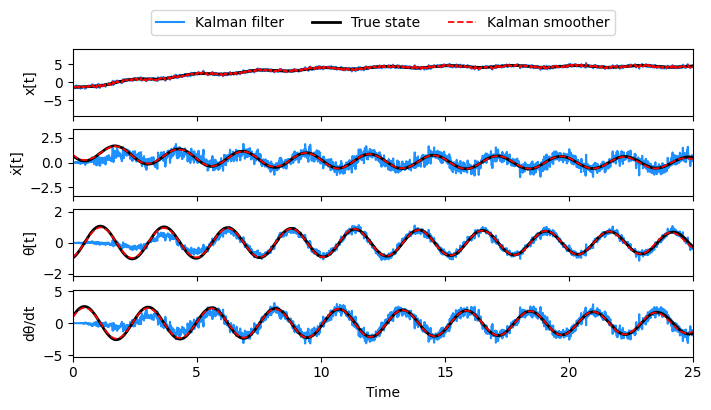

In [23]:
# --> Plot the figure.
fig, axes = plt.subplots(n, 1, figsize=(8, 4), sharex=True)

for i, ax in enumerate(axes):
    ax.plot(t, x[:, i], color="dodgerblue", label="Kalman filter")
    ax.plot(t, x_true[:, i], color="black", label="True state", lw=2)
    ax.plot(t, x̂[:, i], color="red", ls="--", label="Kalman smoother", lw=1.25)
    
    ax.set(xlim=(0, Th))
    ax.set(ylim=(-2*abs(x_true[:, i]).max(), 2*abs(x_true[:, i]).max()))

axes[0].legend(loc="lower center", bbox_to_anchor=(0.5, 1.1), ncol=3)

ylabels = ["x[t]", "ẋ[t]", "θ[t]", "dθ/dt"]
for i, ylabel in enumerate(ylabels):
    axes[i].set(ylabel=ylabel)
    
axes[-1].set(xlabel="Time")

As you can see from the figure above, using solely the prior knowledge of the state-space matrices $(\mathbf{A}, \mathbf{C})$ and the measurements $\left\{ \mathbf{y}_t \right\}$, the Kalman filter is able to quickly track the evolution of the unobserved states of the system.
It is obvious from this figure though that the real-time estimates of the states obtained from by Kalman filtering are not as smooth as those obtained by batch processing the whole sequence with the Kalman smoother.
This slight loss of accuracy is however the price to pay for being able to process the measurement data in real time.

---

## **To go further**

In this final section, we explore quickly some extensions of the Kalman filter methodology we have just been trough.

### **Kalman filtering and the Riccati equation**

As discussed in the previous section, the Kalman filter fundamentally is a time-varying recursive filter defined by

$$
\hat{\mathbf{x}}_{t+1 \vert t+1} = \left( \mathbf{A} - \mathbf{K}_{t+1} \mathbf{C} \right) \hat{\mathbf{x}}_{t \vert t} + \mathbf{K}_{t+1} \mathbf{y}_{t+1}.
$$

In particular, the time-varying nature of this filter comes for the recursive definition of the Kalman gains $\mathbf{K}_t$.
One might thus wonder how do these gains actually evolve over time.
The answer is visible from the figure below, plotting the evolution of the entries of $\mathbf{K}_t$ for our cartpole system as a function of time.

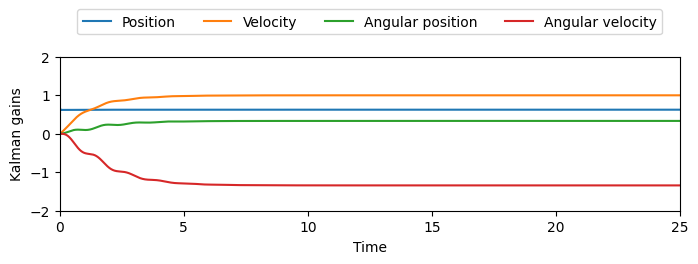

In [24]:
# --> Squeeze array.
Ks = np.squeeze(Ks)

fig, ax = plt.subplots(1, 1, figsize=(8, 2))

ax.plot(t, Ks[:, 0], label="Position")
ax.plot(t, Ks[:, 1], label="Velocity")
ax.plot(t, Ks[:, 2], label="Angular position")
ax.plot(t, Ks[:, 3], label="Angular velocity")

ax.set(xlim=(0, Th), xlabel="Time")
ax.set(ylim=(-2, 2), ylabel="Kalman gains")

ax.legend(loc="lower center", bbox_to_anchor=(0.5, 1.1), ncols=4)

Clearly, the gains quickly attain an asymptotic value.
This behaviour is not too dissimilar from that of the LQR gain matrices we discussed in the previous class, albeit it occurs in the opposite temporal direction.
Once you look a bit deeper into the maths, this actually ain't that surprising.
Recall that the Kalman gain are defined as

$$
\mathbf{K}_{t+1} = \mathbf{P}_{t+1 \vert t} \mathbf{C}^* \left( \mathbf{I} + \mathbf{C} \mathbf{P}_{t+1 \vert t} \mathbf{C}^* \right)^{-1}
$$

where $\mathbf{P}_{t+1 \vert t}$ is the covariance matrix of the predicted state at time $t+1$.
This covariance itself is defined recursively from

$$
\begin{aligned}
    \mathbf{P}_{t \vert t} & = \left( \mathbf{I} - \mathbf{K}_{t} \mathbf{C} \right) \mathbf{P}_{t \vert t-1} \quad & \text{(Covariance correction)} \\
    \mathbf{P}_{t+1 \vert t} & = \mathbf{A} \mathbf{P}_{t \vert t} \mathbf{A}^* + \mathbf{I} \quad & \text{(Covariance prediction)}
\end{aligned}
$$

Before we get started with the calculations, you should have realized by now (if you followed carefully during class) that the equation for the covariance prediction is nothing but a difference [Lyapunov equation](https://en.wikipedia.org/wiki/Lyapunov_equation).
With this clue alone, you may have a hint of where we are going.
Let us start by combining the replacing $\mathbf{P}_{t \vert t}$ in the covariance prediction equation by its expression.
This leads to

$$
\mathbf{P}_{t+1 \vert t} = \mathbf{A} \left( \mathbf{I} - \mathbf{K}_{t} \mathbf{C} \right) \mathbf{P}_{t \vert t-1} \mathbf{A}^* + \mathbf{I}.
$$

Likewise, we can replace $\mathbf{K}_t$ by its definition, yielding

$$
\mathbf{P}_{t+1 \vert t} = \mathbf{A} \left( \mathbf{I} - \mathbf{P}_{t \vert t-1} \mathbf{C}^* \left( \mathbf{I} + \mathbf{C} \mathbf{P}_{t \vert t-1} \mathbf{C}^* \right)^{-1} \mathbf{C} \right) \mathbf{P}_{t \vert t-1} \mathbf{A}^* + \mathbf{I}.
$$

Slight rearrangement of the terms finally leads to

$$
\mathbf{P}_{t+1 \vert t} = \mathbf{A} \mathbf{P}_{t \vert t-1} \mathbf{A}^* - \mathbf{A} \mathbf{P}_{t \vert t-1} \mathbf{C}^* \left( \mathbf{I} + \mathbf{C} \mathbf{P}_{t \vert t-1} \mathbf{C}^* \right)^{-1} \mathbf{C} \mathbf{P}_{t \vert t-1} \mathbf{A}^* + \mathbf{I}.
$$

You should recognize that this is a **Riccati equation**, hence the similarity with the observations we made for the LQR problem.
The only differences with the Linear Quadratic Regulator are that:
- $\mathbf{A}$ is replaced with $\mathbf{A}^*$,
- $\mathbf{B}$ is replaced with $\mathbf{C}^*$,
- The backward Riccati recursion is now replaced with a forward recursion.

These differences come from the same duality existing between the observability of the matrix pair $(\mathbf{A}, \mathbf{C})$ and the controllability of the pair $(\mathbf{A}^*, \mathbf{C}^*)$.
Just like for the LQR problem, this Riccati equation admits a fixed point (under suitable conditions).
This fixed point, corresponding to the asymptotic prediction covariance matrix, is solution to the following algebraic Riccati equation

$$
\mathbf{P} = \mathbf{A} \mathbf{P} \mathbf{A}^* - \mathbf{A} \mathbf{P} \mathbf{C}^* \left( \mathbf{I} + \mathbf{C} \mathbf{P} \mathbf{C}^* \right)^{-1} \mathbf{C} \mathbf{P} \mathbf{A}^* + \mathbf{I}.
$$

Given the solution $\mathbf{P}$ to this equation, we can replace the time-varying Kalman gains with a static one defined as

$$
\mathbf{K} = \mathbf{P} \mathbf{C}^* \left( \mathbf{I} + \mathbf{C} \mathbf{P} \mathbf{C}^* \right)^{-1}.
$$

Following the definition of the static feedback gain in the LQR problem, a second Kalman gain can be defined as

$$
\mathbf{L} = \mathbf{A} \mathbf{P} \mathbf{C}^* \left( \mathbf{I} + \mathbf{C} \mathbf{P} \mathbf{C}^* \right)^{-1}
$$

Using these definition, the Kalman filter can be recast as a *linear time-invariant* recursive filter whose state-space model is given by

$$
\begin{aligned}
    \hat{\mathbf{x}}_{t+1 \vert t} & = \left( \mathbf{A} - \mathbf{LC} \right) \hat{\mathbf{x}}_{t \vert t-1} + \mathbf{L} \mathbf{y}_t \\
    \hat{\mathbf{x}}_{t \vert t}   & = \left( \mathbf{I} - \mathbf{KC} \right) \hat{\mathbf{x}}_{t \vert t-1} + \mathbf{Ky}_t.
\end{aligned}
$$

Because Kalman filters are often used in control problems to infer the state of a partially-observed dynamical systems, they are often called *state observers*.
Due to the duality with the Linear Quadratic Regulator, it also known as the *Linear Quadratic Estimator*.
Using the notation introduced during class, the corresponding system $\Sigma$ can be denoted as

$$
\Sigma =
\begin{pmatrix}
    \begin{array}{c|c}
      \mathbf{A} - \mathbf{LC} & \mathbf{L} \\
      \hline
      \mathbf{I} - \mathbf{KC} & \mathbf{K}
    \end{array}
  \end{pmatrix}.
$$

The `python` cell below uses the function `scipy.linalg.solve_discrete_are` to solve the discrete-time algebraic Riccati equation and construct the `scipy.signal.dlti` state-space representation of the Kalman filter.

In [25]:
# --> Import the Riccati solver.
from scipy.linalg import solve_discrete_are as dare

# --> Solve for the steady-state covariance matrix.
A, C = ssm.A, ssm.C ; m, n = C.shape
P = dare(A.T, C.T, np.eye(n), np.eye(m)) # NOTE: In the derivation we assumed V ~ Im and W ~ In

# --> Definition of the Kalman gains.
K = P @ C.T @ np.linalg.inv(np.eye(m) + C @ P @ C.T)
L = A @ K

# --> Definition of the state space model for the state observer.
observer = dlti( A - L @ C, L, np.eye(n) - K @ C, K, dt=ssm.dt)

Given the definition of this observer, the figure below plots its output when fed with the noisy measurement we have used since the begining of this notebook.

[Text(0.5, 0, 'Time')]

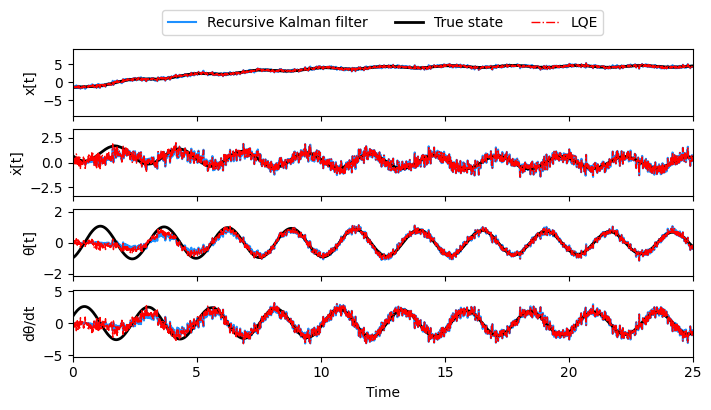

In [26]:
# --> Filter the measurement with the state observer.
t, x_lqe, _ = dlsim(observer, y, x0=x0)

# --> Plot the figure.
fig, axes = plt.subplots(n, 1, figsize=(8, 4), sharex=True)

for i, ax in enumerate(axes):
    ax.plot(t, x[:, i], color="dodgerblue", label="Recursive Kalman filter")
    ax.plot(t, x_true[:, i], color="black", label="True state", lw=2)
    ax.plot(t, x_lqe[:, i], color="red", ls="-.", label="LQE", lw=1)
    
    ax.set(xlim=(0, Th))
    ax.set(ylim=(-2*abs(x_true[:, i]).max(), 2*abs(x_true[:, i]).max()))

axes[0].legend(loc="lower center", bbox_to_anchor=(0.5, 1.1), ncol=3)

ylabels = ["x[t]", "ẋ[t]", "θ[t]", "dθ/dt"]
for i, ylabel in enumerate(ylabels):
    axes[i].set(ylabel=ylabel)
    
axes[-1].set(xlabel="Time")

Except for a short burn-in period (from $t=0$ to $t \simeq 5$), the output of the Linear Quadratic Estimator are on track with the ones for the time-varying Kalman filter.
Because using linear time-invariant observers instead of linear time-varying ones is far more convenient, we will stick to this Linear Quadratic Estimator for the rest of this class.

#### **Generalization to arbitrary noise and process covariance matrices**

So far, we have assumed that the process and sensor noise covariance matrices were both proportional to an identity matrix of appropriate dimensions.
This was due to the use of the ordinary least-squares estimator in order to simplify the derivation of the Kalman filter.
Yet, nothing in the theory prevents us from using the true $n \times n$ process noise covariance matrix $\mathbf{W} \succcurlyeq \mathbf{0}$ and the $m \times m$ sensor noise covariance matrix $\mathbf{V} \succ \mathbf{0}$.
The only difference with what we have done so far is that the Riccati recursion definining the Kalman gains is now given by

$$
\mathbf{P}_{t+1 \vert t} = \mathbf{A} \mathbf{P}_{t \vert t-1} \mathbf{A}^* - \mathbf{A} \mathbf{P}_{t \vert t-1} \mathbf{C}^* \left( \mathbf{V} + \mathbf{C} \mathbf{P}_{t \vert t-1} \mathbf{C}^* \right)^{-1} \mathbf{C} \mathbf{P}_{t \vert t-1} \mathbf{A}^* + \mathbf{W}.
$$

Note however that having access to both the process noise and sensor noise covariance matrices might be complicated for realistic applications.
While the sensor noise covariance matrix can somehow be parsed from the sensors documentation, the process noise covariance matrix often has to be guessed unless a very detailled mechanistic model of the system can be derived.
In practice, these two matrices are often used as tuning knobs to balance how confident we are (or not) in our model versus our sensors.

### **Beyond linear time-invariant dynamical systems**

**Linear time-varying dynamical system -** Although we focused our attention here on *linear time-invariant* dynamical system, nothing in the theoretical framework of Kalman filtering prevents us for applying to a system for which both the dynamics matrix and the measurement operator vary in time.
You can indeed do the exact same analysis by considering a *linear time-varying* dynamical system whose state-space formulation is given by

$$
\begin{aligned}
    \mathbf{x}_{t+1} & = \mathbf{A}_t \mathbf{x}_t + \mathbf{w}_t \\
    \mathbf{y}_t     & = \mathbf{C}_t \mathbf{x}_t + \mathbf{v}_t.
\end{aligned}
$$

The only limitation for linear time-varying (LTV) systems is that the Riccati equation for the covariance matrices no longer admits a fixed point.
As a consequence, the sequence of Kalman gains $\mathbf{K}_t$ cannot be replaced by a static gain matrix $\mathbf{K}$ computed from the solution of an algebraic Riccati equation.
Except for this small technical point, nothing changes otherwise.

**Nonlinear dynamical system -** Kalman filtering can also be applied fairly easily to infer the state of a nonlinear dynamical system

$$
\begin{aligned}
    \mathbf{x}_{t+1} & = f(\mathbf{x}_t) + \mathbf{w}_t \\
    \mathbf{y}_{t}   & = h(\mathbf{x}_t) + \mathbf{v}_t.
\end{aligned}
$$

Using local linearizations, the dynamics function $f : \mathbb{R}^n \to \mathbb{R}^n$ and the measurement operator $h : \mathbb{R}^n \to \mathbb{R}^m$ can be approximated by

$$
\begin{aligned}
    f(\mathbf{x}_{t+1}) \simeq f(\mathbf{x}_t) + \mathbf{A}_t \left( \mathbf{x}_{t+1} - \mathbf{x}_t \right) \\
    h(\mathbf{x}_{t+1}) \simeq h(\mathbf{x}_t) + \mathbf{C}_t \left( \mathbf{x}_{t+1} - \mathbf{x}_t \right),
\end{aligned}
$$

where $\mathbf{A}_t$ and $\mathbf{C}_t$ are the *Jacobian* matrices of $f$ and $h$, respectively.
With the exception of have to linearize locally the model at every time steps, applying Kalman filtering to a nonlinear dynamical is thus no different than applying it a linear time-varying system !